# Natural Language Processing with Disaster Tweets

In [41]:
## Install Libraries
import warnings
warnings.filterwarnings('ignore')

import math
import time
import numpy as np
import pandas as pd 

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

import os
import gc
import cv2 

#from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
#from wordcloud import WordCloud
#from collections import Counter

# Scikit-Learn
import sklearn
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
#from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#from sklearn.ensemble import VotingClassifier
#from sklearn.feature_extraction.text import TfidfVectorizer

# Text cleaning
import string, re
import nltk
nltk.download('wordnet')
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer



# Tensorflow, keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import text, sequence 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Embedding,Activation,Dropout,Flatten,RNN,LSTM,GRU,Bidirectional,TextVectorization, BatchNormalization
from keras.optimizers import RMSprop, SGD, Adam
#from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
#from keras.metrics import AUC
#from gensim.models import Word2Vec


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\shrav\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
'unzip' is not recognized as an internal or external command,
operable program or batch file.
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shrav\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shrav\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## STEP1: Brief description of the problem and data
- Identifying disaster tweets using NLP involves identifying and categorizing tweets that pertain to natural disasters or emergency situations.
- The task is crucial for real-time disaster response,as it helps emergency services to quickly identify and respond to crises.
- The training set consists of 7613 entries of tweets in text(unstructured) format and their target class( 1- disaster , 0 - not disaster).
- The testing set consists of 3263 entries for evaluation.
- Evaluations are done using the F1 score.
​

In [2]:
# Train data
train_df = pd.read_csv('train.csv')
#'/kaggle/input/nlp-getting-started/train.csv'
print(train_df.shape)
train_df.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
train_df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [4]:
train_df.duplicated().sum()

0

In [5]:
# Test data
test_df = pd.read_csv('test.csv')
# '/kaggle/input/nlp-getting-started/test.csv'
print(test_df.shape)
test_df.head()

(3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
test_df.duplicated().sum()

0

In [7]:
test_df.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

## STEP2: Exploratory Data Analysis - Inspect, Visualize and Clean the Data

### Inspect
- Looking at the data and the nature of the problem we want to solve, it's recommended to remove unwanted columns like 'keyword' and 'location' from the raw dataset as most of the entries are missing and it simplifies our data exploration process.

In [8]:
# Removing unwanted columns from train data
train_df = train_df.drop(columns = ['keyword','location'])
train_df.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [9]:
# Removing unwanted columns from test data
test_df.drop(columns = ['keyword','location'], inplace=True)
test_df.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


### Visualize
- Let us examine the distribution of target classes in our train data. 
- Understanding the distribution of the class helps to identify any bias present.

In [10]:
# Count the number of tweets in each class
train_df['target'].value_counts()/len(train_df) * 100

0    57.034021
1    42.965979
Name: target, dtype: float64

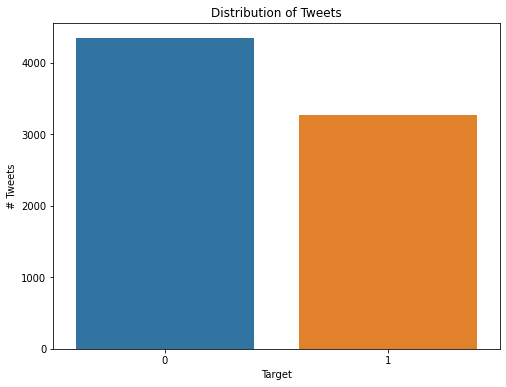

In [11]:
# Plot the distribution of data classes
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Tweets')
plt.xlabel('Target')
plt.ylabel('# Tweets')
plt.show()

- The statistics shows that the data has 57% of tweets which are labelled as 0(not disaster) and 42% of tweets which are labelled as 1 (diasater), as evident in the plot.

In [12]:
# Word,Sentence count using nltk
train_df['word_count'] = train_df['text'].apply(lambda x : len(nltk.word_tokenize(x)))
train_df['sent_count'] = train_df['text'].apply(lambda x : len(nltk.sent_tokenize(x)))
train_df.head()

,id,text,target,word_count,sent_count
0,1,Our Deeds are the Reason of this #earthquake M...,1,14,1
1,4,Forest fire near La Ronge Sask. Canada,1,8,2
2,5,All residents asked to 'shelter in place' are ...,1,24,2
3,6,"13,000 people receive #wildfires evacuation or...",1,9,1
4,7,Just got sent this photo from Ruby #Alaska as ...,1,18,1


In [13]:
# unique sentence count information for visualization purpose
np.unique(train_df['sent_count'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 13, 20, 22], dtype=int64)

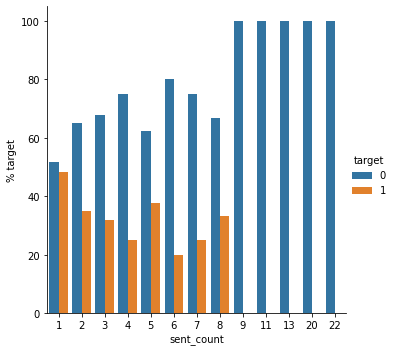

In [14]:
# plot for target distribution based on sentence count
d = train_df.groupby('sent_count')['target'].value_counts(normalize=True).mul(100).rename('% target').reset_index()
p1 = sns.catplot(x = 'sent_count',y = '% target', hue='target',kind='bar', data=d)
plt.show()

-   From the above plot, the tweets classified as disaster are found to be short messages with less than 7 sentences per text. 

In [15]:
# unique sentence count information for visualization purpose
np.unique(train_df['word_count'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 52, 53, 60, 70, 72],
      dtype=int64)

<Figure size 720x720 with 0 Axes>

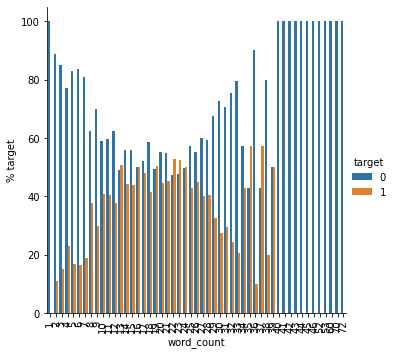

In [18]:
# plot for target distribution based on word count
plt.figure(figsize=(10 ,10))

d = train_df.groupby('word_count')['target'].value_counts(normalize=True).mul(100).rename('% target').reset_index()
p1 = sns.catplot(x = 'word_count',y = '% target', hue='target',kind='bar', data=d)
plt.xticks(rotation = 90)
plt.show()

### Data Preprocessing

- Observing some tweets, we notice some junk characters like hashtags, non-imformative stopwords and URLs, hence the following steps will be followed before model building for a better performance.
- Cleaning(noise removal): Removing hashtags,URLs and any non-standard text like punctuations,special characters,numbers, emojis, exclamation marks, accents, brackets, commas, semicolons which doesn't add any value to the text.
- Tokenization: Splitting tweets into individual words or tokens.
- Normalization:  Converting text to lowercase, stemming, and lemmatization.
- Stopwords Removal: Eliminating common words that do not contribute to meaning (e.g., "the", "is", "in").
- Removing short words of lenth less than 3 characters.
- Lemmatizing


In [22]:
stop_words = stopwords.words('english')

def preprocess(text):
    
    # convert to lower case
    clean_text = text.lower()
    
    # Remove special characters
    clean_text=re.sub(r"(@\[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", clean_text)
    
    # Remove Numbers
    clean_text=re.sub('[0-9]+', '', clean_text)
    
    # Remove stopwords and punctuations
    clean_text = ' '.join([w for w in clean_text.split() if w not in stop_words and w not in string.punctuation] )
    
    # Remove short words less than 3 characters
    clean_text = ' '.join([w for w in clean_text.split() if len(w) > 3])
    
    clean_text = ''.join([WordNetLemmatizer().lemmatize(word) for word in clean_text])
    
    return clean_text



In [23]:
# Train data  
train_df['clean_text'] = train_df['text'].apply(preprocess)
train_df['new_wc'] = train_df['clean_text'].apply(lambda n: len(n.split()))
train_df.head() 

,id,text,target,word_count,sent_count,clean_text,new_wc
0,1,Our Deeds are the Reason of this #earthquake M...,1,14,1,deeds reason earthquake allah forgive,5
1,4,Forest fire near La Ronge Sask. Canada,1,8,2,forest fire near ronge sask canada,6
2,5,All residents asked to 'shelter in place' are ...,1,24,2,residents asked shelter place notified officer...,11
3,6,"13,000 people receive #wildfires evacuation or...",1,9,1,people receive wildfires evacuation orders cal...,6
4,7,Just got sent this photo from Ruby #Alaska as ...,1,18,1,sent photo ruby alaska smoke wildfires pours s...,8


In [24]:
# Test data
test_df['clean_text'] = test_df['text'].apply(preprocess)
test_df['new_wc'] = test_df['clean_text'].apply(lambda n: len(n.split()))
test_df.head() 

,id,text,clean_text,new_wc
0,0,Just happened a terrible car crash,happened terrible crash,3
1,2,"Heard about #earthquake is different cities, s...",heard earthquake different cities stay safe ev...,7
2,3,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese fleeing across str...,10
3,9,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting spokane wildfires,4
4,11,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kills china taiwan,5


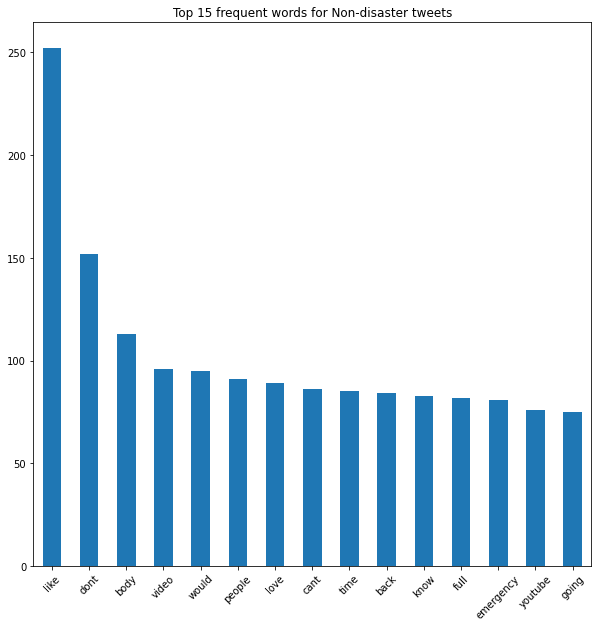

In [25]:
# frequency words plot for Not-disaster tweets
nd_df = train_df[train_df['target'] == 0]
plt.figure(figsize=(10,10))
words = ' '.join(nd_df['clean_text']).split()
w_freq = pd.Series(words).value_counts()
w_freq.head(15).plot(kind='bar')
plt.title("Top 15 frequent words for Non-disaster tweets")
plt.xticks(rotation = 45)
plt.show()

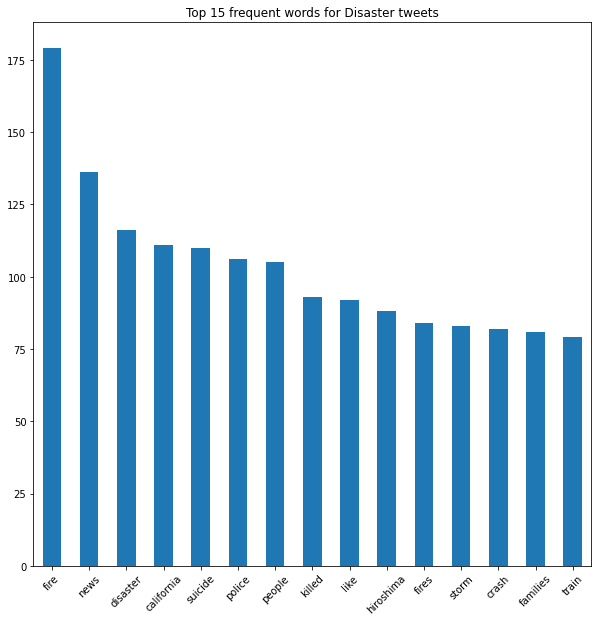

In [26]:
# frequency words plot for Disaster tweets
d_df = train_df[train_df['target'] == 1]
plt.figure(figsize=(10,10))
words = ' '.join(d_df['clean_text']).split()
w_freq = pd.Series(words).value_counts()
w_freq.head(15).plot(kind='bar')
plt.title("Top 15 frequent words for Disaster tweets")
plt.xticks(rotation = 45)
plt.show()

In [27]:
train_df['clean_text'] = train_df['clean_text'].apply(lambda n: n.split())
train_df.head()

,id,text,target,word_count,sent_count,clean_text,new_wc
0,1,Our Deeds are the Reason of this #earthquake M...,1,14,1,"[deeds, reason, earthquake, allah, forgive]",5
1,4,Forest fire near La Ronge Sask. Canada,1,8,2,"[forest, fire, near, ronge, sask, canada]",6
2,5,All residents asked to 'shelter in place' are ...,1,24,2,"[residents, asked, shelter, place, notified, o...",11
3,6,"13,000 people receive #wildfires evacuation or...",1,9,1,"[people, receive, wildfires, evacuation, order...",6
4,7,Just got sent this photo from Ruby #Alaska as ...,1,18,1,"[sent, photo, ruby, alaska, smoke, wildfires, ...",8


In [28]:
test_df['clean_text'] = test_df['clean_text'].apply(lambda n: n.split())
test_df.head()

,id,text,clean_text,new_wc
0,0,Just happened a terrible car crash,"[happened, terrible, crash]",3
1,2,"Heard about #earthquake is different cities, s...","[heard, earthquake, different, cities, stay, s...",7
2,3,"there is a forest fire at spot pond, geese are...","[forest, fire, spot, pond, geese, fleeing, acr...",10
3,9,Apocalypse lighting. #Spokane #wildfires,"[apocalypse, lighting, spokane, wildfires]",4
4,11,Typhoon Soudelor kills 28 in China and Taiwan,"[typhoon, soudelor, kills, china, taiwan]",5


In [29]:
max_len = max(train_df['clean_text'].apply(lambda x: len(x)).values)
max_len

20

In [30]:
# unique sentence count information for visualization purpose
np.unique(train_df['new_wc'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 20], dtype=int64)

<Figure size 720x720 with 0 Axes>

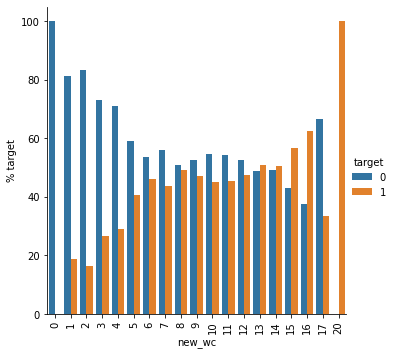

In [31]:
# plot for target distribution based on word count
plt.figure(figsize=(10,10))

d = train_df.groupby('new_wc')['target'].value_counts(normalize=True).mul(100).rename('% target').reset_index()
p1 = sns.catplot(x = 'new_wc',y = '% target', hue='target',kind='bar', data=d)
plt.xticks(rotation = 90)
plt.show()

In [32]:
# unique sentence count information for visualization purpose
max(np.unique(test_df['new_wc']))

18

<AxesSubplot:xlabel='new_wc', ylabel='Count'>

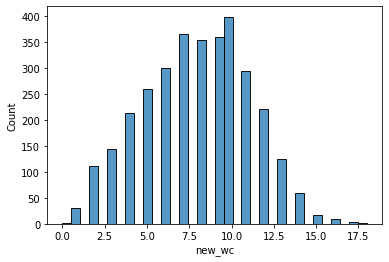

In [33]:
sns.histplot(test_df['new_wc'])

## STEP3: Model Architecture 

###  Feature Extraction:
- Text Representation: Converting text into numerical representations using techniques like Bag of Words (BoW), Term Frequency-Inverse Document Frequency (TF-IDF), or word embeddings (e.g., Word2Vec, GloVe, BERT).

###  Deep Learning Model architecture
- Based on the problem and dataset size,it is a Sequence to Vector RNN problem, so we wil use GRU,LSTM and BiLSTM and compare their performances.
- Stack one or more layers to capture temporal dependencies in the tweet sequences.
- Add fully connected (dense) layers to process the output and produce the final classification. 
- Use dropout layers to prevent overfitting.
- In the output layer, use a sigmoid activation function for binary classification (disaster vs. non-disaster).
 
###  Model Training
- Use binary cross-entropy loss for training the model.
- Select an optimization algorithm such as Adam or RMSprop.
- Choose appropriate batch sizes and the number of epochs for training.
- Split the data into training and validation sets.
- Train the model on the training set while monitoring its performance on the validation set to avoid overfitting.

###  Model Evaluation
- Evaluate the model using the test data and submit the results to kaggle.


In [79]:
## Tokenizer on Clean text
total_tweets = np.concatenate((train_df['clean_text'], test_df['clean_text']))
#print(total_tweets_ct)

tokenizer = Tokenizer(20000)
tokenizer.fit_on_texts(total_tweets)

# Vocbvulary Size on clean_text
vocab_size = len(tokenizer.word_index) + 1
print('Size of Vocabulary : ', vocab_size)

max_len = max(len(x) for x in total_tweets)
print('Maximum length of tweet : ', max_len)
#.split()


Size of Vocabulary :  19910
Maximum length of tweet :  20


In [ ]:
# Text to Sequence conversion
X_train_seq = tokenizer.texts_to_sequences(train_df['clean_text'])
#X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(test_df['clean_text'])
#X_train_seq[:5]

In [ ]:
# Padding
# Padding the sequuences to ensure all are of same length
max_length = max_len
padding_type ='post'
#truncation_type ='post'

X_train_pad = pad_sequences(X_train_seq, maxlen= max_length, padding=padding_type)
#, truncating=truncation_type)
#X_val_pad   = pad_sequences(X_val_seq,   maxlen= max_length, padding=padding_type)
#, padding=padding_type, truncating=truncation_type)
X_test_pad  = pad_sequences(X_test_seq,  maxlen= max_length, padding=padding_type)
#, padding=padding_type, truncating=truncation_type)

#print(X_train_pad)

print(X_train_pad.shape)
#print(X_val_pad.shape)
print(X_test_pad.shape)

### Feature Extraction - Word2Vec Embedding

In [42]:
# ! pip install -U gensim

In [49]:
"""
from gensim.models import Word2Vec
w2v_model = Word2Vec(total_tweets , sg=1 , hs=0, negative = 10, workers=2 , window=5, min_count=2,seed=44)  #size=200,
w2v_model.train(total_tweets, total_examples=len(total_tweets),epochs=10)

# similaraity b/w two words
#w2v_model.wv.similarity('chocolate','birthday')
"""

(726867, 860210)

### Analysis:
- So for model building we will use the values of vocabulary size and maximum length of the tweet.
- vocab_size = 20000
- max_len = 20 or 100

### Let's split the training data into another training and validation dataset.

In [ ]:
train_df.head()

In [54]:
X = train_df['clean_text']
y = train_df['target']
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size = 0.2, random_state = 100)

In [83]:
#X_train.head(10)

In [55]:
#X_train_seq = tokenizer.texts_to_sequences(X_train)
#X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(test_df['clean_text'])

In [62]:
#X_train_seq[:10]

[[371, 260, 495, 79, 314],
 [50, 189, 570, 81, 10283, 10284, 10285, 5793],
 [13570, 497, 13571, 3, 37, 45, 424, 974, 202, 985],
 [665, 650, 6, 439, 552, 6, 912, 10948, 5955],
 [393, 11, 2654, 7677, 200, 828],
 [24, 20, 9683, 64],
 [100, 120, 1183, 1527, 316, 13163, 13164, 1527, 72, 1121],
 [11201, 11202, 11203, 743, 509, 77, 1473, 4386, 138, 1365, 696],
 [2387, 150, 246, 1, 68],
 [794, 6436, 338, 2876, 13100, 883, 339, 563, 463, 834]]

In [84]:
"""
# Padding the sequuences to ensure all are of same length
max_length = max_len
#print(max_length)
padding_type ='post'
truncation_type ='post'

X_train_pad = pad_sequences(X_train_seq, maxlen= max_length, padding=padding_type)
#, truncating=truncation_type)
X_val_pad   = pad_sequences(X_val_seq,   maxlen= max_length, padding=padding_type)
#, padding=padding_type, truncating=truncation_type)
X_test_pad  = pad_sequences(X_test_seq,  maxlen= max_length, padding=padding_type)
#, padding=padding_type, truncating=truncation_type)

print(X_train_pad.shape)
print(X_val_pad.shape)
print(X_test_pad.shape)
"""

"\n# Padding the sequuences to ensure all are of same length\nmax_length = max_len\n#print(max_length)\npadding_type ='post'\ntruncation_type ='post'\n\nX_train_pad = pad_sequences(X_train_seq, maxlen= max_length, padding=padding_type)\n#, truncating=truncation_type)\nX_val_pad   = pad_sequences(X_val_seq,   maxlen= max_length, padding=padding_type)\n#, padding=padding_type, truncating=truncation_type)\nX_test_pad  = pad_sequences(X_test_seq,  maxlen= max_length, padding=padding_type)\n#, padding=padding_type, truncating=truncation_type)\n\nprint(X_train_pad.shape)\nprint(X_val_pad.shape)\nprint(X_test_pad.shape)\n"


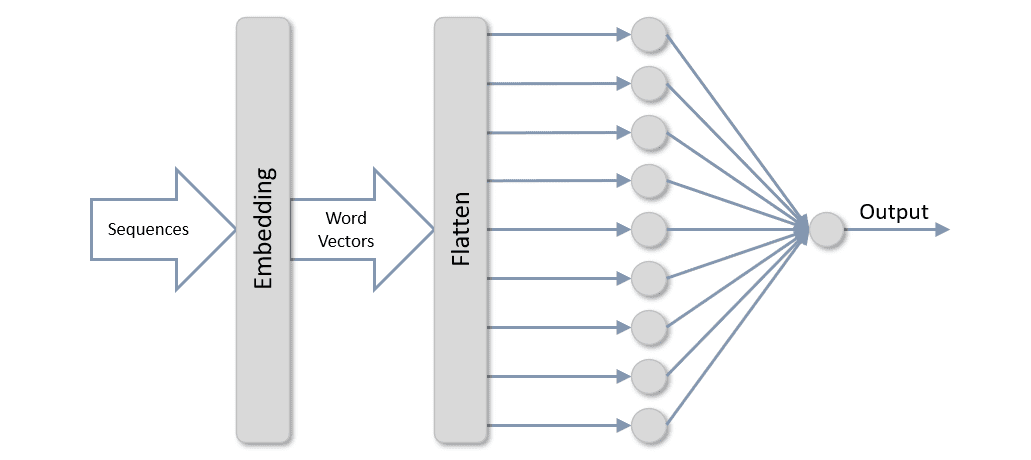

###  GRU Model 
- Requires less training time than other types of recurrent neural networks.
- Has fewer parameters than LSTMs, making it faster to train and less prone to overfitting.
- Better at capturing long-term dependencies than traditional RNNs due to the gating mechanisms that allow selective information retention and forgetting.


In [74]:
# Set parameters
max_features = 20000  # Number of words in the vocabulary built by Tokenizer
max_len = 100  # length of the padded sequence
embed_size = 128  # Dimension of the embedding layer

model_gru = Sequential([
    
    #TextVectorization(max_tokens = max_features,output_mode='int', output_sequence_length=max_len),
    Embedding(max_features , embed_size, input_shape=[None]),
    #Embedding(max_features , embed_size, mask_zero=True, input_length = max_len,input_shape=(max_features,)), 
    GRU(128, return_sequences = True),
    GRU(128),
    #Flatten(),
    #Dense(64, activation='relu'),
    Dropout(0.5), #A dropout layer is added to prevent overfitting.
    Dense(1, activation='sigmoid')
])

model_gru.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, None, 128)           │       2,560,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, None, 128)           │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 128)                 │          99,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,758,273 (10.52 MB)

 Trainable params: 2,758,273 (10.52 MB)

 Non-trainable params: 0 (0.00 B)

- Loss is binary-crossentropy because the cross-entropy loss between true and predicted labels is an excellent measure for binary (0 or 1) classification applications.
- A smaller batch size of 32 is slower in training but can converge faster.

In [75]:
model_gru.compile(loss ="binary_crossentropy" , optimizer = Adam(learning_rate = 0.0001), metrics =['accuracy'])

In [76]:
#history = model_gru.fit(X_train_pad, y_train, batch_size= 32, epochs = 10,validation_data=(X_val_pad, y_val))
history = model_gru.fit(X_train_pad, y , batch_size= 32, epochs = 10, validation_split=0.2)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 28s 130ms/step - accuracy: 0.5735 - loss: 0.6859 - val_accuracy: 0.5719 - val_loss: 0.6832
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 26s 137ms/step - accuracy: 0.5650 - loss: 0.6846 - val_accuracy: 0.5719 - val_loss: 0.6831
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - accuracy: 0.5708 - loss: 0.6834 - val_accuracy: 0.5719 - val_loss: 0.6832
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 25s 133ms/step - accuracy: 0.5686 - loss: 0.6849 - val_accuracy: 0.5719 - val_loss: 0.6832
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - accuracy: 0.5796 - loss: 0.6813 - val_accuracy: 0.5719 - val_loss: 0.6835
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 25s 129ms/step - accuracy: 0.5768 - loss: 0.6819 - val_accuracy: 0.5719 - val_loss: 0.6832
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 25s 130ms/step - accuracy: 0.5741 - loss: 0.6828 - val_accuracy: 0.5719 - val_loss: 0.6831
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 25s 130ms/step - accuracy: 0.5696 - loss: 0

- Loss is binary-crossentropy because the cross-entropy loss between true and predicted labels is an excellent measure for binary (0 or 1) classification applications.
- A smaller batch size of 32 is slower in training but can converge faster.

In [ ]:
# Plot the learning curves 
pd.DataFrame(history.history).plot(figsize=(10,8))
plt.grid(True)
plt.title('Learning_Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.gca().set_xlim(1,10)
plt.gca().set_ylim(0,2) # setting the vertical range to [0-1]
plt.show()

### LSTM Model
- LSTMs are designed to capture long-term dependencies in sequential data.
- LSTMs can handle inputs and outputs of varying lengths.
- LSTMs are capable of learning complex relationships between input and output sequences.



In [ ]:
# Set parameters
max_features = 20000  # Number of words in the vocabulary built by Tokenizer
max_len = 100  # length of the padded sequence
embed_size = 128  # Dimension of the embedding layer 

model_lstm = Sequential([
    #Embedding(max_features , embed_size, input_shape=[None]),
    Embedding(max_features , embed_size, input_length = max_len,input_shape= (max_features,)),
    
    LSTM(64, activation='tanh',return_sequences = True), 
    Dropout(0.5),
    #BatchNormalization(),
    LSTM(64, activation='tanh',return_sequences = False), 
    Dropout(0.5),
    #BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5), #A dropout layer is added to prevent overfitting.
    #BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    #BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_lstm.summary()

In [ ]:
model_lstm.compile(loss ="binary_crossentropy" , optimizer = Adam(learning_rate = 0.0001), metrics =['accuracy'])
history_lstm = model_lstm.fit(X_train_pad, y , batch_size= 32, epochs = 10, validation_split=0.2)
# y_train, validation_data=(X_val_pad, y_val)

In [ ]:
# Plot the learning curves 
pd.DataFrame(history_lstm.history).plot(figsize=(10,8))
plt.grid(True)
plt.title('Learning_Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.gca().set_xlim(1,10)
plt.gca().set_ylim(0,1.2) # setting the vertical range to [0-1]
plt.show()

### BiLSTM Model

In [ ]:
# Set parameters
max_features = 20000  # Number of words in the vocabulary built by Tokenizer
max_len = 100  # length of the padded sequence
embed_size = 128  # Dimension of the embedding layer

model_Blstm = Sequential([
    #Embedding(max_features , embed_size, input_shape=[None]),
    Embedding(max_features , embed_size, input_length = max_len,input_shape= (max_features,)),
    
    Bidirectional(LSTM(64, activation='tanh',return_sequences = True)), 
    Dropout(0.5),
    
    Bidirectional(LSTM(64)), 
    Dropout(0.5),
    
    Dense(256, activation='relu'),
    Dropout(0.5), #A dropout layer is added to prevent overfitting.
   
    Dense(128, activation='relu'),
    Dropout(0.5),
  
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_Blstm.summary()

In [ ]:
model_Blstm.compile(loss ="binary_crossentropy" , optimizer = Adam(learning_rate = 0.0001), metrics =['accuracy'])
history_Blstm = model_Blstm.fit(X_train_pad, y , batch_size= 32, epochs = 10, validation_split=0.2)
# y_train, validation_data=(X_val_pad, y_val)

In [ ]:
# Plot the learning curves 
pd.DataFrame(history_Blstm.history).plot(figsize=(10,8))
plt.grid(True)
plt.title('Learning_Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.gca().set_xlim(1,10)
plt.gca().set_ylim(0,1.2) # setting the vertical range to [0-1]
plt.show()

## STEP4: Results and Analysis
- The data is trained on 3 different architectures GRU, LSTM and BiLSTM.
- The evaluated test results of the 3 models are submitted individually and their scores are compared.
- The Kaggle submission public score of the 7 different models tuned with parameter values are listed:
- 1. The basic GRU model score without tokenizer, sequencing and padding is 0.75789.
- 2. The GRU model score with lemmatizer, tokenizer, sequencing and padding is 0.76310.
- 3. The GRU model score with lemmatizer, tokenizer, sequencing and padding and learning rate of the adam optimer set to 0.0001 is 0.73613.
- 4. The LSTM model score  with lemmatizer, tokenizer, sequencing and padding is 0.60128.
- 5. The LSTM model score  with lemmatizer, tokenizer, sequencing and padding and learning rate of the adam optimer set to 0.0001 is 0.74563. 
- 6. The BiLSTM model score  without tokenizer, sequencing and padding is 0.74256.

## STEP5: Conclusion
### Learning:
- Peforming data preprocessing steps such as Lemmatizing,tokenizing, sequencing and padding on the text data improved the performance score of the models.
- LSTM model's performance improved from 0.60 to 0.745 when the learning rate value of the adam optimizer was set to 0.0001.
- Increasing the Batch size from 32 to 64 slighltly deterirated the model perfromance, hence set the size to 32 for all models later.
- The performance of the BiLSTM model is same as other 2 models.
- Overall there seems to be overfitting on the training data because of the larger variation in accuracies of the training and validation data. 

### Improvements:
- Different feature extraction methods such asTextVectorization, Word2Vec can be implemented to check for any improvement in the scores and reduction in overfitting.


### Kaggle submission

In [ ]:
submission_df = pd.DataFrame()
submission_df['id'] = test_df['id']
submission_df['target'] = list(map(lambda x: 0 if x < 0.5 else 1,np.transpose(model_lstm.predict(X_test_pad, verbose=1))[0]))
submission_df.head()
#submission_df.shape #(3263, 2)

In [ ]:
submission_df.to_csv('submission.csv', index=False)

### References:

1. https://www.geeksforgeeks.org/word-embeddings-in-nlp/
2. https://www.ruder.io/deep-learning-nlp-best-practices/
3. https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456
4. https://medium.com/@caio_emiliano/twitter-sentiment-analysis-a-comprehensive-guide-to-nlp-and-machine-learning-techniques-b5af9cd213a7
5. https://www.atmosera.com/text-classification-with-neural-networks/#:~:text=The%20first%20hidden%20layer%20in,rather%20than%20a%20single%20integer.
6. https://medium.com/@jangidajay271/transforming-unstructured-text-into-structured-insights-with-nlp-techniques-f0537583f563#:~:text=While%20NLP%20has%20traditionally%20been,text%2C%20images%2C%20and%20audio.